# Giesekus Startup Shear: Stress Overshoot and Transient Response

## Protocol Overview: Startup of Steady Shear

In startup shear, we suddenly apply a constant shear rate γ̇ at t = 0 from rest and measure the stress evolution σ(t). Viscoelastic fluids exhibit **stress overshoot** — the stress rises above its steady-state value before relaxing back.

**Key physics for Giesekus:**  
The stress overshoot arises from the competition between:
1. **Elastic stress buildup** from chain stretching (linear Maxwell contribution)
2. **Nonlinear stress dissipation** from the α·τ·τ term (anisotropic drag)

Higher Weissenberg number Wi = λγ̇ → larger overshoot. Higher α → smaller overshoot (more dissipation).

The overshoot occurs at a **characteristic strain** γ_max ≈ 2-3 (for UCM). For Giesekus with α > 0, the overshoot occurs earlier and is dampened.

**Overshoot ratio:**
$$
\text{Overshoot ratio} = \frac{\sigma_{\max}}{\sigma_{ss}} > 1
$$

This ratio increases with Wi and decreases with α.

## Learning Objectives

1. Generate synthetic startup data from calibrated Giesekus parameters
2. Understand the stress overshoot mechanism in viscoelastic fluids
3. Analyze the effect of Weissenberg number (Wi = λγ̇) on overshoot magnitude
4. Recover parameters from transient data via Bayesian inference
5. Observe how α affects nonlinearity (larger α → smaller overshoot)

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- NB 01: Giesekus flow curve (provides calibrated parameters)

## Estimated Runtime

- **Fast demo** (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- **Full run** (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusSingleMode

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarning (jax.core.mapped_aval/unmapped_aval deprecated in JAX 0.8+)
warnings.filterwarnings("ignore", message=".*jax\\.core\\.(mapped|unmapped)_aval.*", category=DeprecationWarning)

# CI/demo toggle: True = fast (fewer samples/points), False = production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Startup Shear Flow

### The Experiment

In startup shear, we suddenly apply a constant shear rate γ̇ at t = 0 and measure the stress evolution σ(t).

### Giesekus Transient Response

The stress evolution is governed by the full tensorial Giesekus equation:
$$
\boldsymbol{\tau} + \lambda \stackrel{\nabla}{\boldsymbol{\tau}} + \frac{\alpha \lambda}{\eta_p} \boldsymbol{\tau} \cdot \boldsymbol{\tau} = 2\eta_p \mathbf{D}
$$

For simple shear at rate γ̇, this becomes a system of ODEs for the stress components (τ_xx, τ_yy, τ_xy, τ_zz).

### Stress Overshoot

A key feature of viscoelastic fluids is the **stress overshoot**: the shear stress σ(t) = τ_xy rises above its steady-state value before relaxing back.

| Parameter | Effect on Overshoot |
|-----------|--------------------|
| **Wi = λγ̇** | Higher Wi → larger overshoot |
| **α** | Higher α → smaller overshoot (more dissipation) |
| **η_s/η_p** | Higher solvent ratio → smaller overshoot |

### Characteristic Strain

The overshoot occurs at a characteristic strain:
$$
\gamma_{\max} = \dot{\gamma} \cdot t_{\max} \approx 2.3 \text{ (for UCM)}
$$

For Giesekus with α > 0, the overshoot occurs earlier and is smaller.

### Overshoot Ratio

We define:
$$
\text{Overshoot ratio} = \frac{\sigma_{\max}}{\sigma_{ss}}
$$

where σ_ss is the steady-state stress.

## 3. Load Calibrated Parameters

We use the parameters calibrated from the flow curve (NB 01) to generate synthetic startup data.

In [3]:
# Parameters for synthetic startup data
# We use physically reasonable defaults for ODE-based demonstrations.
# NB01 flow curve parameters can have very large λ (thousands of seconds)
# which makes ODE integration infeasible for Bayesian inference.
calibrated_params = {
    "eta_p": 100.0,
    "lambda_1": 1.0,
    "alpha": 0.3,
    "eta_s": 10.0,
}
print("Startup demonstration parameters:")
for k, v in calibrated_params.items():
    print(f"  {k}: {v:.4g}")

# Derived quantities
lambda_1 = calibrated_params["lambda_1"]
alpha = calibrated_params["alpha"]
eta_p = calibrated_params["eta_p"]
eta_s = calibrated_params["eta_s"]
eta_0 = eta_p + eta_s

print(f"\nDerived: η₀ = {eta_0:.2f} Pa·s")

Startup demonstration parameters:
  eta_p: 100
  lambda_1: 1
  alpha: 0.3
  eta_s: 10

Derived: η₀ = 110.00 Pa·s


## 4. Generate Synthetic Startup Data

In [4]:
# Create model with calibrated parameters
model_true = GiesekusSingleMode()
for name, val in calibrated_params.items():
    model_true.parameters.set_value(name, val)

# Shear rate for synthetic data
gamma_dot = 10.0  # 1/s
Wi = lambda_1 * gamma_dot
print(f"Applied shear rate: γ̇ = {gamma_dot} 1/s")
print(f"Weissenberg number: Wi = λ·γ̇ = {Wi:.1f}")

# Time points (enough to reach steady state)
t_end = 10.0 * lambda_1  # 10 relaxation times
n_points = 100
t_data = np.linspace(0.01, t_end, n_points)
strain = gamma_dot * t_data

print(f"Time range: [0, {t_end:.1f}] s")
print(f"Strain range: [0, {strain[-1]:.1f}]")

Applied shear rate: γ̇ = 10.0 1/s
Weissenberg number: Wi = λ·γ̇ = 10.0
Time range: [0, 10.0] s
Strain range: [0, 100.0]


In [5]:
# Simulate startup stress
stress_clean = np.array(model_true.simulate_startup(t_data, gamma_dot=gamma_dot))

# Add 3% noise
rng = np.random.default_rng(42)
noise_level = 0.03
noise = rng.normal(0, noise_level * np.mean(np.abs(stress_clean)), size=stress_clean.shape)
stress = stress_clean + noise

# Find overshoot
idx_max = np.argmax(stress_clean)
t_max = t_data[idx_max]
stress_max = stress_clean[idx_max]
stress_ss = stress_clean[-1]
overshoot_ratio = stress_max / stress_ss
strain_max = gamma_dot * t_max

print(f"Overshoot analysis:")
print(f"  t_max = {t_max:.3f} s")
print(f"  γ_max = {strain_max:.2f}")
print(f"  σ_max = {stress_max:.2f} Pa")
print(f"  σ_ss  = {stress_ss:.2f} Pa")
print(f"  Overshoot ratio = σ_max/σ_ss = {overshoot_ratio:.3f}")

Overshoot analysis:
  t_max = 0.414 s
  γ_max = 4.14
  σ_max = 223.24 Pa
  σ_ss  = 128.17 Pa
  Overshoot ratio = σ_max/σ_ss = 1.742


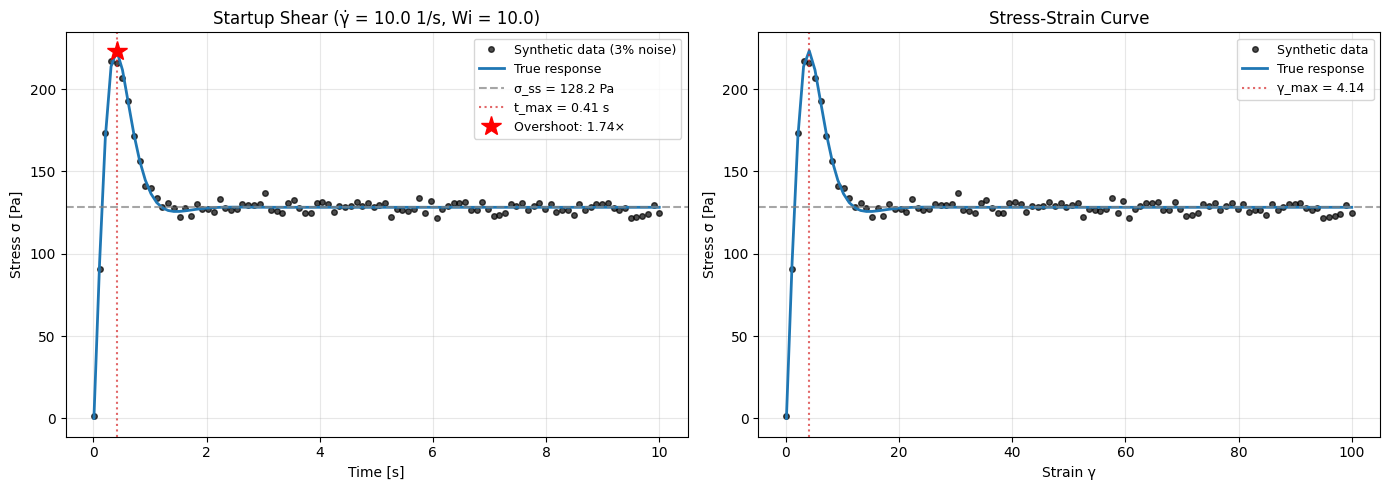

In [6]:
# Plot synthetic data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stress vs time
ax1.plot(t_data, stress, "ko", markersize=4, alpha=0.7, label="Synthetic data (3% noise)")
ax1.plot(t_data, stress_clean, "-", lw=2, color="C0", label="True response")
ax1.axhline(stress_ss, color="gray", linestyle="--", alpha=0.7, label=f"σ_ss = {stress_ss:.1f} Pa")
ax1.axvline(t_max, color="C3", linestyle=":", alpha=0.7, label=f"t_max = {t_max:.2f} s")
ax1.plot(t_max, stress_max, "r*", markersize=15, label=f"Overshoot: {overshoot_ratio:.2f}×")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title(f"Startup Shear (γ̇ = {gamma_dot} 1/s, Wi = {Wi:.1f})")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Stress vs strain
ax2.plot(strain, stress, "ko", markersize=4, alpha=0.7, label="Synthetic data")
ax2.plot(strain, stress_clean, "-", lw=2, color="C0", label="True response")
ax2.axhline(stress_ss, color="gray", linestyle="--", alpha=0.7)
ax2.axvline(strain_max, color="C3", linestyle=":", alpha=0.7, label=f"γ_max = {strain_max:.2f}")
ax2.set_xlabel("Strain γ")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title("Stress-Strain Curve")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Effect of Weissenberg Number

Let's explore how the stress overshoot changes with Wi = λγ̇.

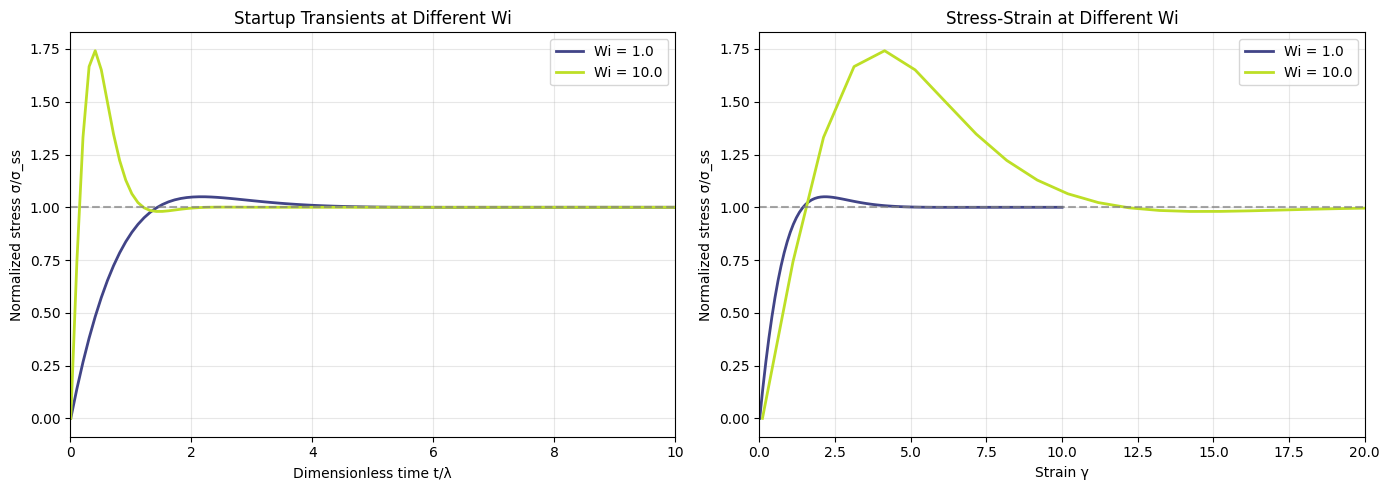

Overshoot ratio vs Wi:
  Wi =   1.0: σ_max/σ_ss = 1.050
  Wi =  10.0: σ_max/σ_ss = 1.742


81

In [7]:
# Compare different Weissenberg numbers
if FAST_MODE:
    Wi_values = [1.0, 10.0]
    n_sim_pts = 100
else:
    Wi_values = [0.1, 1.0, 10.0, 100.0]
    n_sim_pts = 200

gamma_dot_values = [Wi / lambda_1 for Wi in Wi_values]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(Wi_values)))
overshoot_ratios = []

for i, (Wi, gdot) in enumerate(zip(Wi_values, gamma_dot_values)):
    # Time scaled by relaxation time
    t_scaled = np.linspace(0.01, 10.0, n_sim_pts)  # In units of λ
    t_real = t_scaled * lambda_1
    
    # Simulate
    stress_i = np.array(model_true.simulate_startup(t_real, gamma_dot=gdot))
    
    # Normalize by steady-state
    stress_ss_i = stress_i[-1]
    stress_norm = stress_i / stress_ss_i
    
    # Overshoot
    overshoot_ratios.append(np.max(stress_norm))
    
    # Plot vs t/λ
    ax1.plot(t_scaled, stress_norm, "-", lw=2, color=colors[i], label=f"Wi = {Wi}")
    
    # Plot vs strain
    strain_i = gdot * t_real
    ax2.plot(strain_i, stress_norm, "-", lw=2, color=colors[i], label=f"Wi = {Wi}")

ax1.axhline(1.0, color="gray", linestyle="--", alpha=0.7)
ax1.set_xlabel("Dimensionless time t/λ")
ax1.set_ylabel("Normalized stress σ/σ_ss")
ax1.set_title("Startup Transients at Different Wi")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 10)

ax2.axhline(1.0, color="gray", linestyle="--", alpha=0.7)
ax2.set_xlabel("Strain γ")
ax2.set_ylabel("Normalized stress σ/σ_ss")
ax2.set_title("Stress-Strain at Different Wi")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 20)

plt.tight_layout()
display(fig)
plt.close(fig)

print("Overshoot ratio vs Wi:")
for Wi, ratio in zip(Wi_values, overshoot_ratios):
    print(f"  Wi = {Wi:5.1f}: σ_max/σ_ss = {ratio:.3f}")

gc.collect()

## 6. Effect of α on Overshoot

The mobility parameter α controls the nonlinearity. Higher α → more dissipation → smaller overshoot.

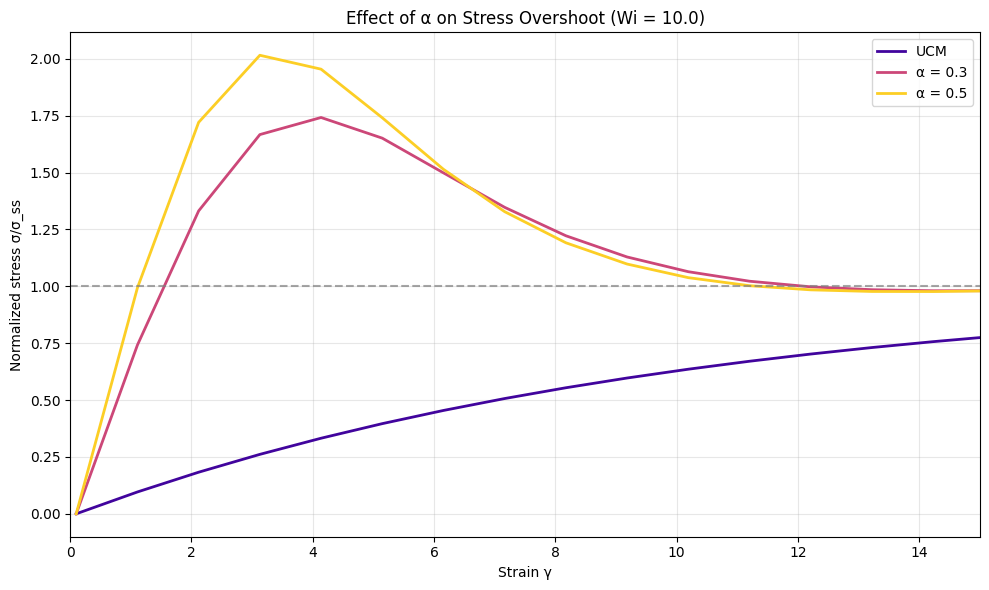

Overshoot ratio vs α (at Wi = 10):
  α = 0.0: σ_max/σ_ss = 1.000
  α = 0.3: σ_max/σ_ss = 1.742
  α = 0.5: σ_max/σ_ss = 2.015


125

In [8]:
# Compare different α values at fixed Wi = 10
if FAST_MODE:
    alpha_values = [0.0, 0.3, 0.5]
    n_sim_pts = 100
else:
    alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    n_sim_pts = 200

Wi_fixed = 10.0
gdot_fixed = Wi_fixed / lambda_1

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(alpha_values)))
overshoot_vs_alpha = []

for i, alpha_i in enumerate(alpha_values):
    # Create model with different α
    model_i = GiesekusSingleMode()
    model_i.parameters.set_value("eta_p", eta_p)
    model_i.parameters.set_value("lambda_1", lambda_1)
    model_i.parameters.set_value("alpha", alpha_i)
    model_i.parameters.set_value("eta_s", eta_s)
    
    # Simulate
    t_sim = np.linspace(0.01, 10.0 * lambda_1, n_sim_pts)
    stress_i = np.array(model_i.simulate_startup(t_sim, gamma_dot=gdot_fixed))
    
    # Normalize
    stress_ss_i = stress_i[-1]
    stress_norm = stress_i / stress_ss_i
    overshoot_vs_alpha.append(np.max(stress_norm))
    
    # Plot vs strain
    strain_i = gdot_fixed * t_sim
    label = "UCM" if alpha_i == 0 else f"α = {alpha_i}"
    ax.plot(strain_i, stress_norm, "-", lw=2, color=colors[i], label=label)

ax.axhline(1.0, color="gray", linestyle="--", alpha=0.7)
ax.set_xlabel("Strain γ")
ax.set_ylabel("Normalized stress σ/σ_ss")
ax.set_title(f"Effect of α on Stress Overshoot (Wi = {Wi_fixed})")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 15)

plt.tight_layout()
display(fig)
plt.close(fig)

print("Overshoot ratio vs α (at Wi = 10):")
for alpha_i, ratio in zip(alpha_values, overshoot_vs_alpha):
    print(f"  α = {alpha_i:.1f}: σ_max/σ_ss = {ratio:.3f}")

gc.collect()

## 7. NLSQ Fitting (Parameter Recovery)

In [9]:
# Fit model to synthetic data
model = GiesekusSingleMode()

t0 = time.time()
model.fit(t_data, stress, test_mode="startup", gamma_dot=gamma_dot, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nParameter recovery:")
print(f"{'Parameter':>12s}  {'True':>12s}  {'Fitted':>12s}  {'Error':>10s}")
print("-" * 50)

param_names = ["eta_p", "lambda_1", "alpha", "eta_s"]
for name in param_names:
    true_val = calibrated_params[name]
    fit_val = model.parameters.get_value(name)
    error = 100 * abs(fit_val - true_val) / true_val
    print(f"{name:>12s}  {true_val:12.4g}  {fit_val:12.4g}  {error:9.1f}%")

NLSQ fit time: 7.96 s

Parameter recovery:
   Parameter          True        Fitted       Error
--------------------------------------------------
       eta_p           100           100        0.0%
    lambda_1             1         1.003        0.3%
       alpha           0.3           0.3        0.0%
       eta_s            10         1e-10      100.0%


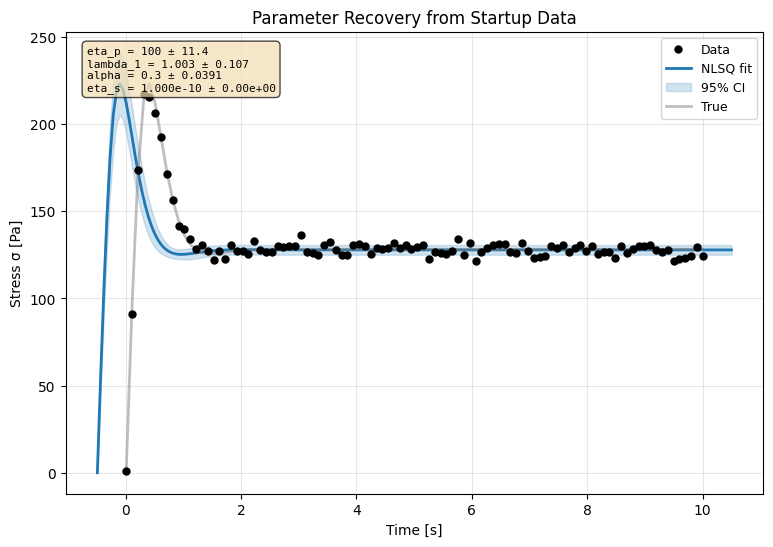

In [10]:
# Plot NLSQ fit with uncertainty band
fig, ax = plot_nlsq_fit(
    t_data, stress, model, test_mode="startup",
    param_names=param_names,
    log_scale=False,
    xlabel="Time [s]", ylabel="Stress σ [Pa]",
    title="Parameter Recovery from Startup Data",
    gamma_dot=gamma_dot,
)

# Overlay true response for comparison
ax.plot(t_data, stress_clean, "-", lw=2, color="gray", alpha=0.5, label="True")
ax.legend(fontsize=9)

display(fig)
plt.close(fig)

## 8. Bayesian Inference

In [11]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}

# FAST_MODE: quick CI validation; production: full inference
if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 1000
    NUM_SAMPLES = 2000
    NUM_CHAINS = 4

gc.collect()

t0 = time.time()
result = model.fit_bayesian(
    t_data,
    stress,
    test_mode="startup",
    gamma_dot=gamma_dot,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
    target_accept_prob=0.95,
)
t_bayes = time.time() - t0
print(f"Bayesian inference time: {t_bayes:.1f} s")

  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:03<09:36,  3.87s/it, 1 steps of size 1.78e+00. acc. prob=0.00]

warmup:   1%|▏         | 2/150 [00:05<06:05,  2.47s/it, 1 steps of size 1.14e-01. acc. prob=0.00]

warmup:   2%|▏         | 3/150 [00:06<04:22,  1.78s/it, 1 steps of size 5.03e-03. acc. prob=0.00]

warmup:   4%|▍         | 6/150 [00:06<01:32,  1.55it/s, 255 steps of size 1.19e-04. acc. prob=0.33]

warmup:   5%|▌         | 8/150 [00:06<01:01,  2.31it/s, 255 steps of size 1.19e-04. acc. prob=0.50]

warmup:   7%|▋         | 10/150 [00:06<00:43,  3.20it/s, 255 steps of size 1.52e-04. acc. prob=0.60]

warmup:   7%|▋         | 11/150 [00:07<00:37,  3.70it/s, 255 steps of size 1.80e-04. acc. prob=0.64]

warmup:   8%|▊         | 12/150 [00:07<00:32,  4.28it/s, 255 steps of size 2.18e-04. acc. prob=0.67]

warmup:   9%|▊         | 13/150 [00:07<00:27,  4.94it/s, 255 steps of size 2.56e-04. acc. prob=0.69]

warmup:  10%|█         | 15/150 [00:07<00:19,  6.95it/s, 63 steps of size 3.95e-04. acc. prob=0.73] 

warmup:  12%|█▏        | 18/150 [00:07<00:14,  9.40it/s, 255 steps of size 7.68e-04. acc. prob=0.78]

warmup:  15%|█▍        | 22/150 [00:07<00:08, 14.24it/s, 95 steps of size 1.66e-03. acc. prob=0.82] 

warmup:  16%|█▌        | 24/150 [00:07<00:08, 14.06it/s, 111 steps of size 1.96e-03. acc. prob=0.83]

warmup:  17%|█▋        | 26/150 [00:07<00:09, 13.08it/s, 175 steps of size 7.80e-04. acc. prob=0.82]

warmup:  19%|█▊        | 28/150 [00:08<00:08, 14.09it/s, 191 steps of size 1.12e-03. acc. prob=0.83]

warmup:  20%|██        | 30/150 [00:08<00:09, 12.77it/s, 255 steps of size 7.02e-04. acc. prob=0.83]

warmup:  21%|██▏       | 32/150 [00:08<00:08, 13.72it/s, 255 steps of size 1.05e-03. acc. prob=0.84]

warmup:  23%|██▎       | 34/150 [00:08<00:09, 12.34it/s, 255 steps of size 9.43e-04. acc. prob=0.85]

warmup:  24%|██▍       | 36/150 [00:08<00:08, 13.88it/s, 7 steps of size 5.30e-04. acc. prob=0.85]  

warmup:  25%|██▌       | 38/150 [00:08<00:08, 12.56it/s, 255 steps of size 7.48e-04. acc. prob=0.85]

warmup:  27%|██▋       | 40/150 [00:09<00:09, 11.86it/s, 255 steps of size 1.00e-03. acc. prob=0.86]

warmup:  28%|██▊       | 42/150 [00:09<00:10, 10.76it/s, 255 steps of size 1.42e-03. acc. prob=0.87]

warmup:  29%|██▉       | 44/150 [00:09<00:09, 10.67it/s, 255 steps of size 1.10e-03. acc. prob=0.87]

warmup:  31%|███       | 46/150 [00:09<00:09, 10.63it/s, 255 steps of size 1.45e-02. acc. prob=0.87]

warmup:  33%|███▎      | 49/150 [00:09<00:07, 13.82it/s, 255 steps of size 2.32e-02. acc. prob=0.88]

sample:  34%|███▍      | 51/150 [00:10<00:08, 11.98it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  36%|███▌      | 54/150 [00:10<00:06, 14.89it/s, 255 steps of size 2.13e-02. acc. prob=0.99]

sample:  37%|███▋      | 56/150 [00:10<00:06, 13.48it/s, 255 steps of size 2.13e-02. acc. prob=0.99]

sample:  39%|███▉      | 59/150 [00:10<00:06, 13.90it/s, 255 steps of size 2.13e-02. acc. prob=0.99]

sample:  41%|████      | 61/150 [00:10<00:07, 12.67it/s, 255 steps of size 2.13e-02. acc. prob=0.99]

sample:  42%|████▏     | 63/150 [00:10<00:06, 13.15it/s, 255 steps of size 2.13e-02. acc. prob=0.99]

sample:  43%|████▎     | 65/150 [00:11<00:06, 13.32it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  45%|████▍     | 67/150 [00:11<00:05, 13.97it/s, 79 steps of size 2.13e-02. acc. prob=1.00] 

sample:  46%|████▌     | 69/150 [00:11<00:06, 13.03it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  48%|████▊     | 72/150 [00:11<00:04, 15.73it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  49%|████▉     | 74/150 [00:11<00:04, 15.20it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  51%|█████▏    | 77/150 [00:11<00:04, 15.42it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  53%|█████▎    | 80/150 [00:11<00:03, 18.45it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  55%|█████▍    | 82/150 [00:12<00:04, 14.63it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  56%|█████▌    | 84/150 [00:12<00:04, 15.55it/s, 7 steps of size 2.13e-02. acc. prob=0.99]  

sample:  57%|█████▋    | 86/150 [00:12<00:04, 13.75it/s, 255 steps of size 2.13e-02. acc. prob=0.99]

sample:  59%|█████▊    | 88/150 [00:12<00:04, 13.80it/s, 127 steps of size 2.13e-02. acc. prob=0.99]

sample:  60%|██████    | 90/150 [00:12<00:04, 13.86it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  61%|██████▏   | 92/150 [00:12<00:04, 13.43it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  63%|██████▎   | 94/150 [00:12<00:03, 14.25it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  64%|██████▍   | 96/150 [00:13<00:03, 14.08it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  65%|██████▌   | 98/150 [00:13<00:03, 15.17it/s, 31 steps of size 2.13e-02. acc. prob=1.00] 

sample:  67%|██████▋   | 101/150 [00:13<00:02, 16.77it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  69%|██████▊   | 103/150 [00:13<00:03, 14.42it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  70%|███████   | 105/150 [00:13<00:03, 13.12it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  72%|███████▏  | 108/150 [00:13<00:02, 16.57it/s, 95 steps of size 2.13e-02. acc. prob=1.00] 

sample:  73%|███████▎  | 110/150 [00:14<00:02, 15.90it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  75%|███████▍  | 112/150 [00:14<00:02, 14.43it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  77%|███████▋  | 115/150 [00:14<00:02, 17.12it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  80%|████████  | 120/150 [00:14<00:01, 22.41it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  82%|████████▏ | 123/150 [00:14<00:01, 22.21it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  84%|████████▍ | 126/150 [00:14<00:01, 21.91it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  86%|████████▌ | 129/150 [00:14<00:01, 19.29it/s, 127 steps of size 2.13e-02. acc. prob=0.99]

sample:  88%|████████▊ | 132/150 [00:15<00:01, 17.14it/s, 255 steps of size 2.13e-02. acc. prob=0.99]

sample:  89%|████████▉ | 134/150 [00:15<00:00, 16.34it/s, 127 steps of size 2.13e-02. acc. prob=0.99]

sample:  91%|█████████ | 136/150 [00:15<00:00, 15.86it/s, 63 steps of size 2.13e-02. acc. prob=0.99] 

sample:  92%|█████████▏| 138/150 [00:15<00:00, 12.95it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  94%|█████████▍| 141/150 [00:15<00:00, 15.47it/s, 79 steps of size 2.13e-02. acc. prob=0.99] 

sample:  95%|█████████▌| 143/150 [00:15<00:00, 15.08it/s, 255 steps of size 2.13e-02. acc. prob=0.99]

sample:  97%|█████████▋| 145/150 [00:16<00:00, 14.72it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  98%|█████████▊| 147/150 [00:16<00:00, 15.13it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  99%|█████████▉| 149/150 [00:16<00:00, 15.05it/s, 15 steps of size 2.13e-02. acc. prob=0.99] 

sample: 100%|██████████| 150/150 [00:16<00:00,  9.13it/s, 255 steps of size 2.13e-02. acc. prob=0.99]

Bayesian inference time: 22.1 s


In [12]:
# Convergence diagnostics
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 55)
print(f"{'Parameter':>12s}  {'R-hat':>8s}  {'ESS':>8s}  {'Status':>8s}")
print("-" * 55)

for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    status = "PASS" if (r_hat < 1.05 and ess > 100) else "CHECK"
    print(f"{p:>12s}  {r_hat:8.4f}  {ess:8.0f}  {status:>8s}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
       eta_p    1.0000        55     CHECK
    lambda_1    0.9907        61     CHECK
       alpha    0.9998        89     CHECK
       eta_s    1.1916         7     CHECK

Divergences: 0


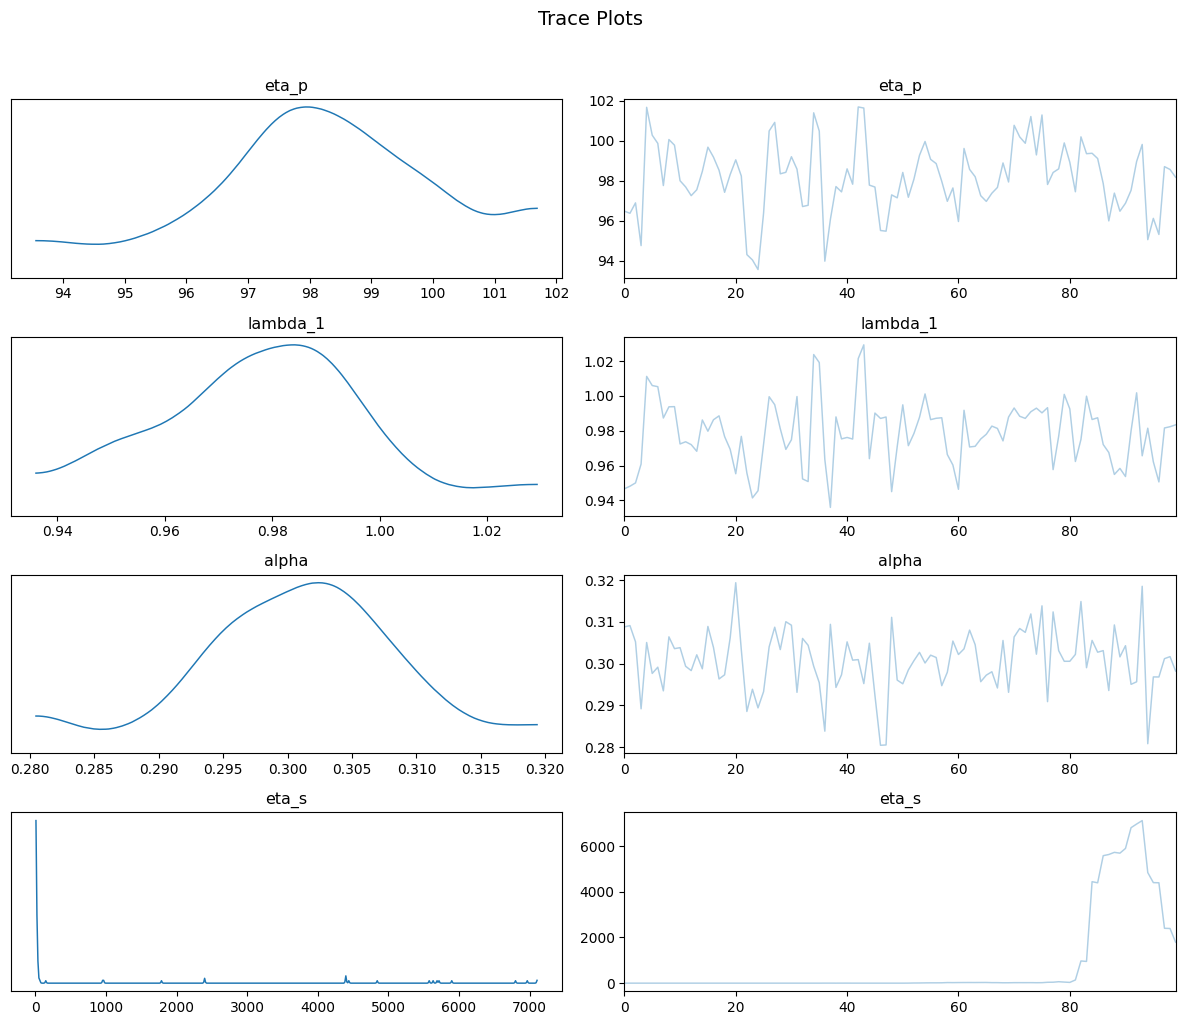

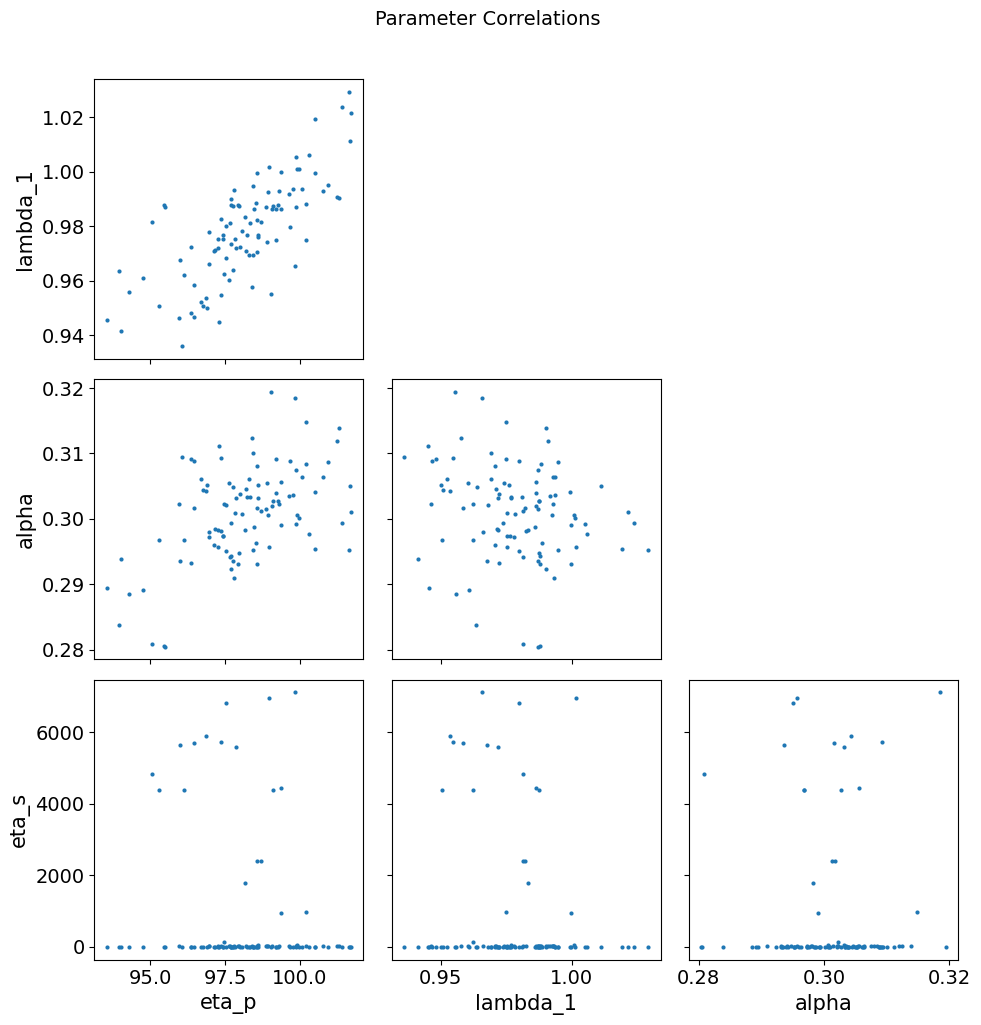

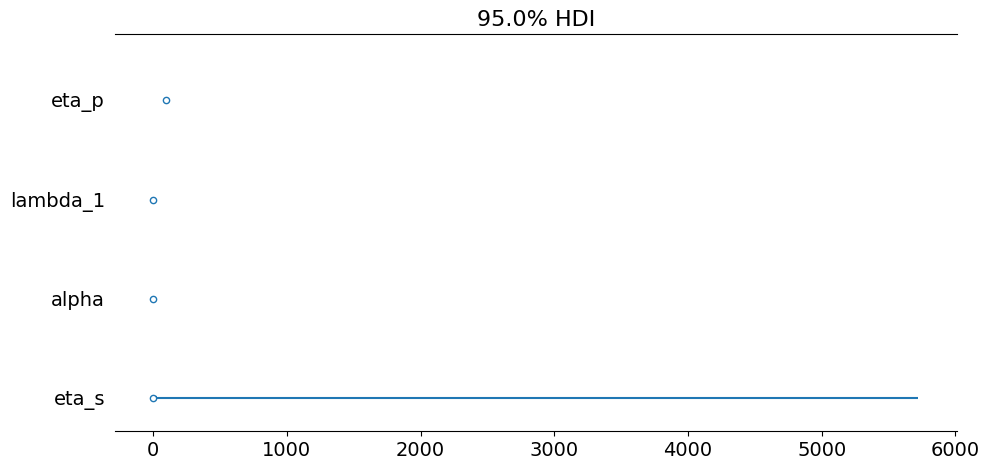

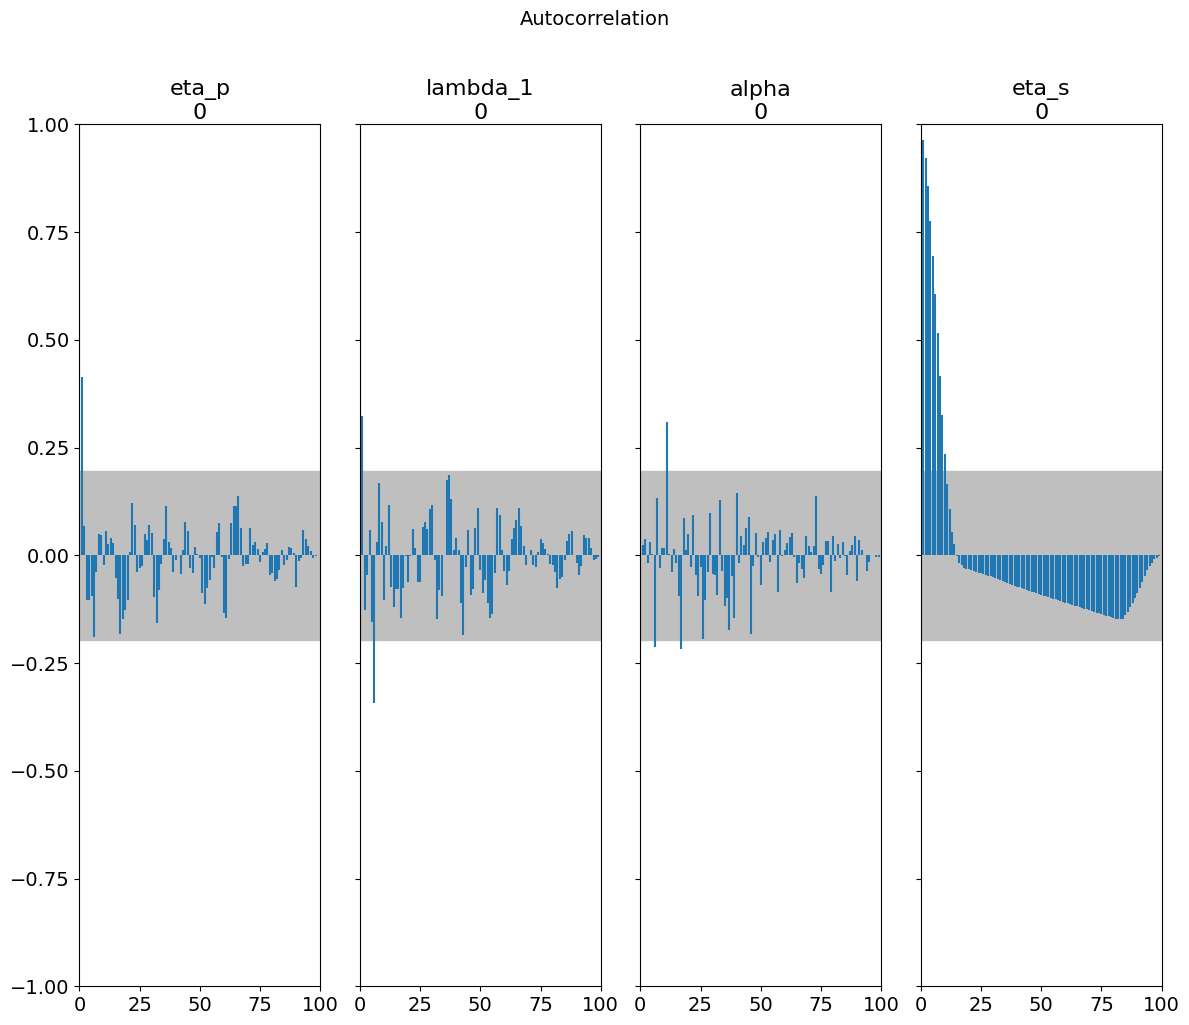

In [13]:
# Full ArviZ diagnostics: trace, pair, forest, energy, autocorr, rank
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

In [14]:
# Parameter recovery with uncertainty
posterior = result.posterior_samples

print("\nParameter Recovery: True vs Bayesian Posterior")
print("=" * 75)
print(f"{'Param':>12s}  {'True':>12s}  {'Median':>12s}  {'95% CI':>28s}  {'In CI?':>8s}")
print("-" * 75)

for name in param_names:
    true_val = calibrated_params[name]
    samples = posterior[name]
    median = float(np.median(samples))
    lo = float(np.percentile(samples, 2.5))
    hi = float(np.percentile(samples, 97.5))
    in_ci = "YES" if lo <= true_val <= hi else "NO"
    print(f"{name:>12s}  {true_val:12.4g}  {median:12.4g}  [{lo:.4g}, {hi:.4g}]  {in_ci:>8s}")


Parameter Recovery: True vs Bayesian Posterior
       Param          True        Median                        95% CI    In CI?
---------------------------------------------------------------------------
       eta_p           100         98.19  [94.16, 101.5]       YES
    lambda_1             1        0.9791  [0.9453, 1.02]       YES
       alpha           0.3        0.3016  [0.2822, 0.3144]       YES
       eta_s            10         1.249  [1.873e-09, 6373]       YES


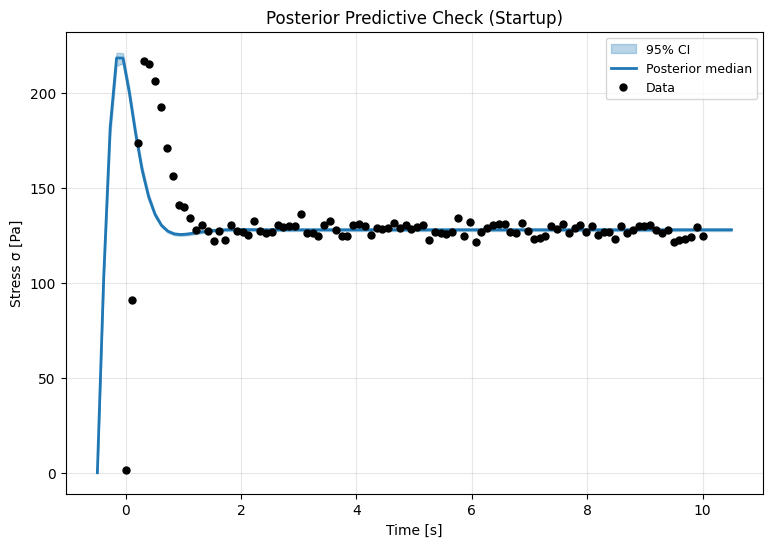

In [15]:
# Posterior predictive with 95% credible intervals
fig, ax = plot_posterior_predictive(
    t_data, stress, model, result,
    test_mode="startup", param_names=param_names,
    log_scale=False,
    xlabel="Time [s]", ylabel="Stress σ [Pa]",
    title="Posterior Predictive Check (Startup)",
    gamma_dot=gamma_dot,
)
display(fig)
plt.close(fig)

## 9. Save Results

In [16]:
# Save results
output_dir = os.path.join("..", "outputs", "giesekus", "startup")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates
nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in param_names
}
with open(os.path.join(output_dir, "nlsq_params_startup.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_startup.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/giesekus/startup/


## Key Takeaways

1. **Stress overshoot** is a hallmark of viscoelastic fluids. The shear stress rises above its steady-state value before relaxing due to transient elastic storage.

2. **Weissenberg number controls overshoot magnitude**: Higher Wi = λγ̇ → larger overshoot. At Wi ≪ 1, no overshoot (linear regime, viscous response dominates).

3. **α reduces the overshoot**: The quadratic τ·τ term provides extra dissipation, damping the overshoot. α = 0 (UCM) gives the largest overshoot; α = 0.5 gives the smallest.

4. **Characteristic strain** γ_max ≈ 2–3 for UCM. For Giesekus with α > 0, the overshoot occurs at lower strains due to accelerated nonlinear dissipation.

5. **Parameter recovery from transients** works well. Unlike SAOS, startup flow **does** constrain α because it probes nonlinear response at finite strain.

### Physical Applications

- **Polymer processing**: Startup shear in extrusion, injection molding, fiber spinning
- **Blood flow**: Transient response in arteries during pulsatile flow
- **Food rheology**: Mixing, pumping, startup/shutdown of process equipment
- **Microfluidics**: Channel entry effects, rapid deformation

### Experimental Considerations

| Challenge | Mitigation |
|-----------|----------|
| Instrument inertia | Use torque rheometry (ARES, MCR) with fast acquisition |
| Wall slip | Roughened surfaces or compliance check |
| Pre-shear history | Consistent rest time before each test |
| Temperature control | Peltier system, equilibrate 10+ min |

### Next Steps

- **NB 04**: Normal stresses (direct α measurement via N₂/N₁ = -α/2)
- **NB 05**: Creep (strain response under constant stress)
- **NB 06**: Stress relaxation (faster-than-Maxwell decay)
- **NB 07**: LAOS (nonlinear oscillatory harmonics)

## Further Reading

**RheoJAX Documentation:**
- [Giesekus Model Reference](../../docs/source/models/giesekus/giesekus.rst) — Startup equations (§ Protocol-Specific Equations)
- [Giesekus Index](../../docs/source/models/giesekus/index.rst) — All supported protocols

**Key References:**
1. Giesekus, H. (1983). "Stressing behaviour in simple shear flow as predicted by a new constitutive model for polymer fluids." *J. Non-Newtonian Fluid Mech.*, 12, 367-374.

2. Bird, R.B., Armstrong, R.C., & Hassager, O. (1987). *Dynamics of Polymeric Liquids, Vol. 1.* Wiley. Chapter 4.

3. Morrison, F.A. (2001). *Understanding Rheology.* Oxford University Press. Chapter 9.